In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.mobilenet import MobileNet



In [2]:
# tfds.load 는 데이터를 다운로드 및 캐시하고 tf.data.Dataset 객체를 리턴
# 'cats_vs_dogs' 데이터셋은 train / test 데이터 split 을 지원하지 않아
# subsplit 을 사용하여 train 80% validation 10% test 10%로 데이터를 나눔
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

# tf.data.Dataset 객체는 (image, label) pair 로 이루어져 있음
print(raw_train)
print(raw_validation)
print(raw_test)

# 결과 저장 경로
TRAINED_MODEL_PATH = 'models_mobilenet'

# Class 개수와 이미지 크기 지정
NUM_CLASSES = 2              # Cat vs Dog Dataset 은 10개의 class 를 가지고 있음
IMG_HEIGHT = 224             # ImageNet 데이터셋으로 사전학습된 MobileNet 입력 크기
IMG_WIDTH = 224

# Epoch 횟수와 batch size, learning rate, dropout ratio 지정
EPOCHS = 10                 # 학습 반복 횟수 지정
BATCH_SIZE = 32             # 학습에 사용할 mini-batch 크기
LEARNING_RATE = 0.001       # Optimizer 에 사용할 learning rate
DROP_OUT_RATIO = 0.2        # Dropout 비율
SHUFFLE_BUFFER_SIZE = 1000

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [3]:
print('metadata', metadata)

metadata tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_path='C:\\Users\\innos\\tensorflow_datasets\\cats_vs_dogs\\4.0.0',
    download_size=786.68 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon an

In [4]:
get_label_name = metadata.features['label'].int2str
print(get_label_name)

<bound method ClassLabel.int2str of ClassLabel(shape=(), dtype=tf.int64, num_classes=2)>


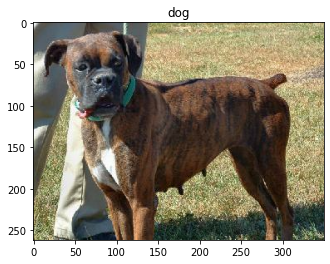

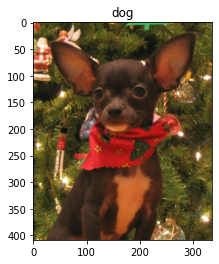

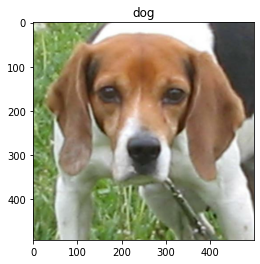

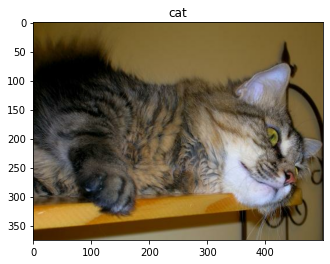

In [5]:
# Train 용 데이터셋에서 처음 두 개의 이미지와 label 을 확인
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(4):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [6]:
# tf.image module 을 사용하여 image 변경
# Image 를 학습에 맞게 고정 크기로 변경하고 입력 채널의 크기를 [-1, 1] 범위로 조정
def format_exchange(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
  return image, label

# map 함수를 이용하여 각각의 데이터셋에 적용
train = raw_train.map(format_exchange)
validation = raw_validation.map(format_exchange)
test = raw_test.map(format_exchange)

# 데이터를 shuffle 하고 batch 크기만큼 구분
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

for image_batch, label_batch in train_batches.take(1):
   pass

print(image_batch.shape)

(32, 224, 224, 3)


In [7]:
# ImageNet 으로 사전학습된 MobileNet 모델 생성
# 'Cats vs Dogs' 데이터셋은 2개의 클래스만 존재하고 ImageNet 은 1000개의 클래스가 존재하기 때문에
# top-layer (Global Average Pooling + 1x1 Conv(FC Layer 대체)) 를 사용할 수 없음
base_model = MobileNet(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),# 입력 크기 설정
                       alpha=1.0,                             # Alpha = 1
                       depth_multiplier=1,                    # Depth multiplier = 1
                       dropout=DROP_OUT_RATIO,                # Dropout ratio 설정
                       include_top=False,                     # Pooling 및 Dense layer 미포함
                       weights='imagenet',                    # ImageNet 으로 사전학습된 파라미터 로드
                       input_tensor=None,                     # input_tensor 미지정
                       pooling=None,                          # Conv layer 이후 pooling 미사용
                       classes=NUM_CLASSES)                   # Class 개수 설정

# base_model 은 ImageNet 데이터셋으로 사전학습된 CNN으로
# 영상을 base_model에 입력하면 영상의 feature map 을 구할 수 있음
features = base_model(image_batch)

# Top-layer 구현부
# base_model 에는 top-layer 가 존재하지 않으므로
# Global Average Pooling layer 와 Dense layer 를 직접 구현하여야 함
gap_layer = tf.keras.layers.GlobalAveragePooling2D()          # Global Average Pooling layer
gap_batch = gap_layer(features)
pred_layer= tf.keras.layers.Dense(1)                          # FC Layer
pred_batch= pred_layer(gap_batch)

# base_model을 포함한 모든 layer를 Sequential model 로 생성
model = tf.keras.Sequential([
    base_model,
    gap_layer,
    pred_layer
])

# 학습에 사용할 Adam optimizer 및 loss function 생성
optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
losses = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# 모델 컴파일(optimizer, loss 지정)
model.compile(optimizer=optimizer,
              loss=losses,
              metrics=['acc'])

In [8]:
# Base model 확인
base_model.summary()

# 생성한 모델 확인
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [9]:
# ImageNet 데이터셋으로 사전 학습된 모델에 'Cats vs Dogs' 데이터셋을 입력하여
# 생성한 모델의 정확도 확인
before_loss, before_acc = model.evaluate(test_batches, steps=50)
print('Before Training : Test Loss : {:.4f}, Test Accuracy : {:.2f}%'.format(
    before_loss, 100.*before_acc))

50/50 [==============================] - 2s 40ms/step - loss: 0.8918 - acc: 0.5088
Before Training : Test Loss : 0.8918, Test Accuracy : 50.88%


In [10]:
# Checkpoint 저장을 위한 callback
# TRAINED_MODEL_PATH 에 'val_acc' 기준으로 최대값이 갱신될 때마다 저장하도록 구현
save_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath='trained_model\checkpoint',
                monitor='val_acc', verbose=1, save_best_only=True,
                save_weights_only=False, mode='max', save_freq='epoch')

# 필요한 callback 을 list 로 지정
callback_list = [save_callback]

# 학습 진행
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches,
                    callbacks=[callback_list])

Epoch 1/10
582/582 [==============================] - ETA: 0s - loss: 0.1225 - acc: 0.9546
Epoch 00001: val_acc improved from -inf to 0.96991, saving model to trained_model\checkpoint
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: trained_model\checkpoint\assets


INFO:tensorflow:Assets written to: trained_model\checkpoint\assets


582/582 [==============================] - 135s 232ms/step - loss: 0.1225 - acc: 0.9546 - val_loss: 0.0805 - val_acc: 0.9699
Epoch 2/10
582/582 [==============================] - ETA: 0s - loss: 0.0694 - acc: 0.9713
Epoch 00002: val_acc did not improve from 0.96991
582/582 [==============================] - 105s 181ms/step - loss: 0.0694 - acc: 0.9713 - val_loss: 0.2223 - val_acc: 0.9071
Epoch 3/10
582/582 [==============================] - ETA: 0s - loss: 0.0547 - acc: 0.9782
Epoch 00003: val_acc did not improve from 0.96991
582/582 [==============================] - 105s 181ms/step - loss: 0.0547 - acc: 0.9782 - val_loss: 0.0785 - val_acc: 0.9678
Epoch 4/10
582/582 [==============================] - ETA: 0s - loss: 0.0417 - acc: 0.9846
Epoch 00004: val_acc improved from 0.96991 to 0.97635, saving model to trained_model\checkpoint
INFO:tensorflow:Assets written to: trained_model\checkpoint\assets


INFO:tensorflow:Assets written to: trained_model\checkpoint\assets


582/582 [==============================] - 128s 219ms/step - loss: 0.0417 - acc: 0.9846 - val_loss: 0.0575 - val_acc: 0.9764
Epoch 5/10
582/582 [==============================] - ETA: 0s - loss: 0.0406 - acc: 0.9854
Epoch 00005: val_acc did not improve from 0.97635
582/582 [==============================] - 102s 176ms/step - loss: 0.0406 - acc: 0.9854 - val_loss: 0.2385 - val_acc: 0.9394
Epoch 6/10
582/582 [==============================] - ETA: 0s - loss: 0.0336 - acc: 0.9872
Epoch 00006: val_acc did not improve from 0.97635
582/582 [==============================] - 105s 180ms/step - loss: 0.0336 - acc: 0.9872 - val_loss: 0.2199 - val_acc: 0.9420
Epoch 7/10
582/582 [==============================] - ETA: 0s - loss: 0.0304 - acc: 0.9885
Epoch 00007: val_acc did not improve from 0.97635
582/582 [==============================] - 101s 173ms/step - loss: 0.0304 - acc: 0.9885 - val_loss: 0.0631 - val_acc: 0.9755
Epoch 8/10
582/582 [==============================] - ETA: 0s - loss: 0.0287 

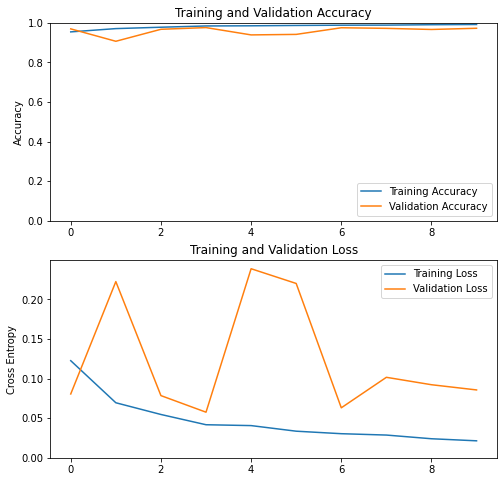

In [11]:
# Training accuracy 및 validation accuracy
acc = history.history['acc']
val_acc = history.history['val_acc']

# Training loss 및 validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# matplotlib 를 이용하여 accuracy 및 loss 출력
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [12]:
# 학습한 모델의 정확도 확인
after_loss, after_acc = model.evaluate(test_batches, steps=50)
print('After Training : Test Loss : {:.4f}, Test Accuracy : {:.2f}%'.format(
    after_loss, 100.*after_acc))

50/50 [==============================] - 2s 40ms/step - loss: 0.0666 - acc: 0.9725
After Training : Test Loss : 0.0666, Test Accuracy : 97.25%
